### Digits

In [99]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_digits
import itertools 
from scipy import linalg
import matplotlib as mpl
import random


from scipy.stats import kurtosis,entropy
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm


import matplotlib.pyplot as plt
from time import clock
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans as kmeans
from sklearn.mixture import GaussianMixture as GMM
from collections import defaultdict, Counter
from sklearn.metrics import adjusted_mutual_info_score as ami, accuracy_score as acc
from sklearn.metrics import homogeneity_score, completeness_score, homogeneity_completeness_v_measure
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import SparseRandomProjection
from itertools import product
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.base import TransformerMixin,BaseEstimator
import scipy.sparse as sps
from scipy.linalg import pinv
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import warnings
warnings.simplefilter('ignore')



In [98]:
digits = load_digits(return_X_y=True)
digitsX,digitsY = digits

digits = np.hstack((digitsX, np.atleast_2d(digitsY).T))
digits = pd.DataFrame(digits)
cols = list(range(digits.shape[1]))
cols[-1] = 'Class'
digits.columns = cols

digitsX = digits.drop('Class',1).copy().values
digitsY = digits['Class'].copy().values


In [20]:
le = preprocessing.LabelEncoder()
Y = le.fit_transform(digitsY)
X = StandardScaler().fit_transform(digitsX)

In [21]:
# Train - Test split# Train  
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size  = 0.2)


In [22]:
print(digitsY)

[ 0.  1.  2. ...,  8.  9.  8.]


In [149]:
def kmeans_silhoutte(X, y, title):
    #print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.


    range_n_clusters = [4,5,6,7,8,9,10,11,12,13,14,15,16]

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(12,5)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = kmeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        #ax1.set_title("Figure 1c: kMeans silhouette plot (Cancer Dataset)")
        ax1.set_xlabel("Silhouette coefficient values")
        #ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--", label="Average Silhouette Score")
        #ax1.axvline(x=0.161, color="red", linestyle="--", label="Average Silhouette Score")
        

        #ax1.set_yticks([])  # Clear the yaxis labels / ticks
        #ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        #ax2.set_title("The visualization of the clustered data.")
        #ax2.set_xlabel("Feature space for the 1st feature")
        #ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle((title+
                      "Silhouette analysis  with n_clusters = %d" % n_clusters),
                     fontsize=14)

    plt.show()

In [152]:
def compute_bic_score(X,title1, title2):
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 20)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = GMM(n_components=n_components,
                                          covariance_type=cv_type)
            gmm.fit(X)
            bic.append(gmm.bic(X))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm

    bic = np.array(bic)
    color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                                  'darkorange'])

    print("BIC score = ", lowest_bic)
    print("BIC scores = ", bic)
    # Plot the BIC scores
    plt.figure(figsize=(8, 6))
    clf = best_gmm
    bars = []
    spl = plt.subplot(2, 1, 1)
    for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
        xpos = np.array(n_components_range) + .2 * (i - 2)
        bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                      (i + 1) * len(n_components_range)],
                            width=.2, color=color))
    plt.xticks(n_components_range)
    plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
    plt.title(title1)
    xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
        .2 * np.floor(bic.argmin() / len(n_components_range))
    plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
    spl.set_xlabel('Number of components')
    spl.legend([b[0] for b in bars], cv_types)
    #plt.show()
    #plt.close()

    # Plot the winner
    #splot = plt.subplot(2, 1, 2)
    Y_ = clf.predict(X)
    '''
    for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                               color_iter)):
        v, w = linalg.eigh(cov)
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan2(w[0][1], w[0][0])
        angle = 180. * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(.5)
        splot.add_artist(ell)
    
    plt.xticks(())
    plt.yticks(())
    plt.title(title2)
    plt.subplots_adjust(hspace=.35, bottom=.02)
    '''
    plt.show()
    plt.close()

In [28]:
print('Part 1 - Running clustering algoirthms on Digits Dataset')

np.random.seed(0)
clusters =  [2,3,4,5,6,7,8,9,10,11,12,13,14,16,18,20,25,30]

dims_digits = range(2,65)


SSE = defaultdict(dict)
BIC = defaultdict(dict)
homo = defaultdict(dict)
compl = defaultdict(dict)
adjMI = defaultdict(dict)
vmeasure = defaultdict(dict)
complete = defaultdict(dict)
km = kmeans(random_state=5)
gmm = GMM(random_state=5)

st = clock()
for k in clusters:
    km.set_params(n_clusters=k)
    gmm.set_params(n_components=k)
    
    km = km.fit(X_train)
    gmm.fit(X_train)
    #SSE[k]['Cancer'] = km.score(X_train)
    SSE[k]['Digits'] = (km.inertia_)
    
    BIC[k]['Digits BIC'] = gmm.bic(X_train)
    #BIC[k]['Cancer BIC'] = gmm.score(X_train)
    
    homo[k]['Kmeans'] = homogeneity_score(Y_train,km.predict(X_train))
    homo[k]['GMM'] = homogeneity_score(Y_train,gmm.predict(X_train))
    
    compl[k]['Kmeans'] = completeness_score(Y_train,km.predict(X_train))
    compl[k]['GMM'] = completeness_score(Y_train,gmm.predict(X_train))
    
    adjMI[k]['Kmeans'] = ami(Y_train,km.predict(X_train))
    adjMI[k]['GMM'] = ami(Y_train,gmm.predict(X_train))
    
    
    a,b,vmeasure_ = homogeneity_completeness_v_measure(Y_train,km.predict(X_train))
    vmeasure[k]['Kmeans'] = vmeasure_
    
    a,b,vmeasure_ = homogeneity_completeness_v_measure(Y_train,gmm.predict(X_train))
    vmeasure[k]['GMM'] = vmeasure_
    #print(k, clock()-st)
    
    
#SSE = (-pd.DataFrame(SSE)).T
SSE = (pd.DataFrame(SSE)).T
#SSE.rename(columns = lambda x: x+' SSE (left)',inplace=True)
BIC = pd.DataFrame(BIC).T
#ll.rename(columns = lambda x: x+' log-likelihood',inplace=True)

homo = pd.DataFrame(homo).T #pd.Panel(homo)
compl = pd.DataFrame(compl).T
adjMI = pd.DataFrame(adjMI).T
complete = pd.DataFrame(complete).T
vmeasure = pd.DataFrame(vmeasure).T

SSE.to_csv('./Part1/Digits_Cluster_Select_Kmeans.csv')
BIC.to_csv('./Part1/Digits_Cluster_Select_GMM.csv')

homo.to_csv('./Part1/digits_homo.csv')
compl.to_csv('./Part1/digits_compl.csv')
adjMI.to_csv('./Part1/digits_adjMI.csv')
complete.to_csv('./Part1/digits_complete.csv')
vmeasure.to_csv('./Part1/digits_vmeasure.csv')

Part 1 - Running clustering algoirthms on Digits Dataset


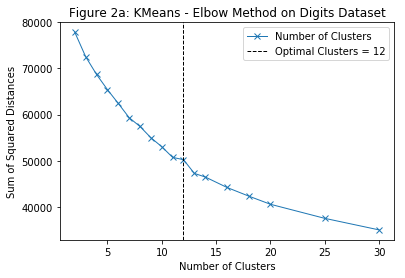

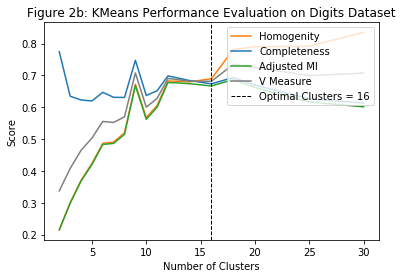

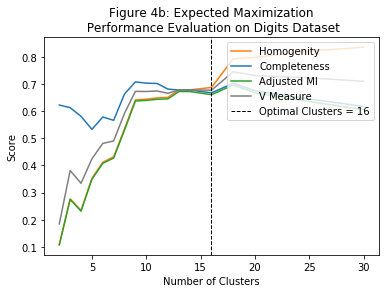

In [52]:
km_df1 = pd.read_csv("./Part1/Digits_Cluster_Select_Kmeans.csv", header='infer')
em_df1 = pd.read_csv("./Part1/Digits_Cluster_Select_GMM.csv", header='infer')

homo_df1 = pd.read_csv("./Part1/digits_homo.csv", header = 'infer')
compl_df1 = pd.read_csv("./Part1/digits_compl.csv", header = 'infer')
adjmi_df1 = pd.read_csv("./Part1/digits_adjMI.csv", header = 'infer')

complete_df1 = pd.read_csv("./Part1/digits_complete.csv", header = 'infer')
vmeasure_df1 = pd.read_csv("./Part1/digits_vmeasure.csv", header = 'infer')

x_data = homo_df1['Unnamed: 0']
plt.close()
#plt.figure(figsize = (12,8))
plt.plot(x_data, km_df1['Digits'], 'bx-', color = 'tab:blue', linewidth = 1, label = "Number of Clusters" )
plt.axvline(x=12 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Clusters = 12")
plt.legend(loc='best')
plt.title("Figure 2a: KMeans - Elbow Method on Digits Dataset")
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Distances");
plt.show()
plt.close()


#plt.figure(figsize = (12,8))
plt.plot(x_data, homo_df1['Kmeans'], color = 'tab:orange',  label = "Homogenity" )
plt.plot(x_data, compl_df1['Kmeans'], color = 'tab:blue',  label = "Completeness" )
plt.plot(x_data, adjmi_df1['Kmeans'], color = 'tab:green',  label = "Adjusted MI" )
plt.plot(x_data, vmeasure_df1['Kmeans'], color = 'tab:gray',  label = "V Measure" )
plt.axvline(x=16 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Clusters = 16")

plt.legend(loc='upper right')
plt.title("Figure 2b: KMeans Performance Evaluation on Digits Dataset")
plt.xlabel("Number of Clusters")
plt.ylabel("Score");
plt.show()
plt.close()


plt.plot(x_data, em_df1['Digits BIC'], 'bx-', color = 'tab:blue', linewidth = 1, label = "Number of Clusters" )
plt.axvline(x=12 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Cluster = 12")
plt.legend(loc='best')
plt.title("Figure 4b: Expected Maximization\nBIC on Digits Dataset")
plt.xlabel("Number of Clusters")
plt.ylabel("BIC");
#plt.show()
plt.close()


#plt.figure(figsize = (12,8))
plt.plot(x_data, homo_df1['GMM'], color = 'tab:orange',  label = "Homogenity" )
plt.plot(x_data, compl_df1['GMM'], color = 'tab:blue',  label = "Completeness" )
plt.plot(x_data, adjmi_df1['GMM'], color = 'tab:green',  label = "Adjusted MI" )
plt.plot(x_data, vmeasure_df1['GMM'], color = 'tab:gray',  label = "V Measure" )
plt.axvline(x=16 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Clusters = 16")
plt.legend(loc='upper right')
plt.title("Figure 4b: Expected Maximization\n Performance Evaluation on Digits Dataset")
plt.xlabel("Number of Clusters")
plt.ylabel("Score");
plt.show()
plt.close()

For n_clusters = 4 The average silhouette_score is : 0.0984300363406
For n_clusters = 5 The average silhouette_score is : 0.102199421748
For n_clusters = 6 The average silhouette_score is : 0.120352151124
For n_clusters = 7 The average silhouette_score is : 0.117363065642
For n_clusters = 8 The average silhouette_score is : 0.126728395114
For n_clusters = 9 The average silhouette_score is : 0.136316359175
For n_clusters = 10 The average silhouette_score is : 0.148248528508
For n_clusters = 11 The average silhouette_score is : 0.153699124076
For n_clusters = 12 The average silhouette_score is : 0.151989911367
For n_clusters = 13 The average silhouette_score is : 0.149859643471
For n_clusters = 14 The average silhouette_score is : 0.157384593188
For n_clusters = 15 The average silhouette_score is : 0.161549145429
For n_clusters = 16 The average silhouette_score is : 0.152345296652


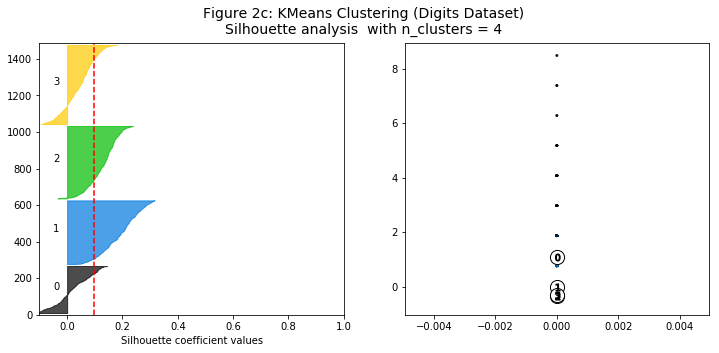

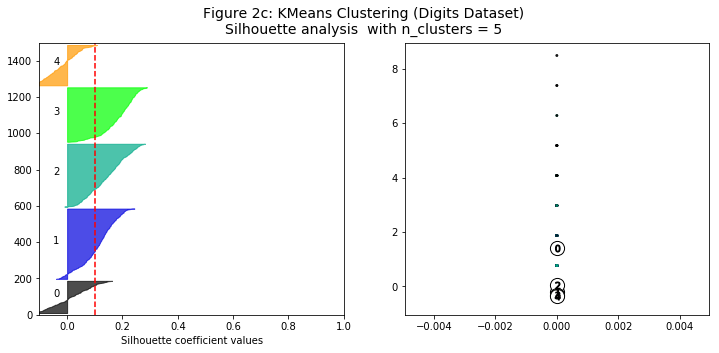

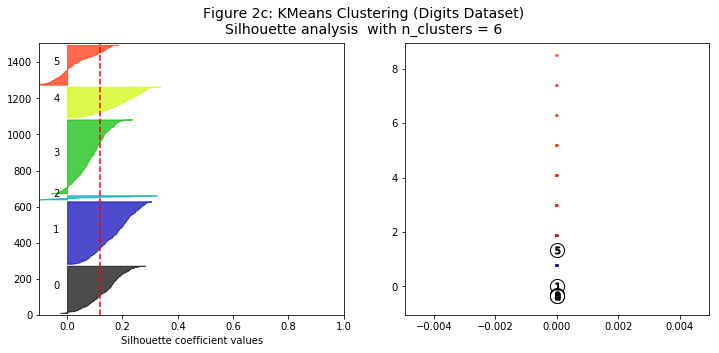

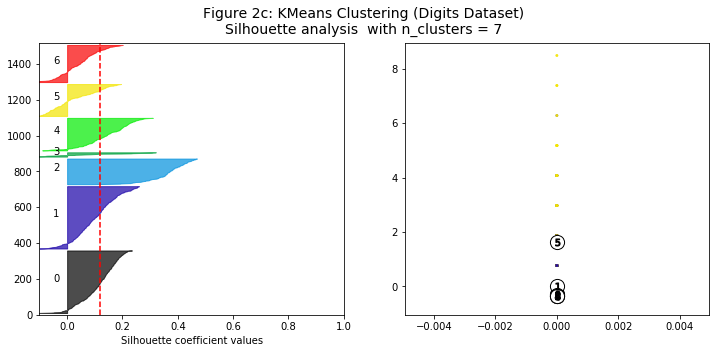

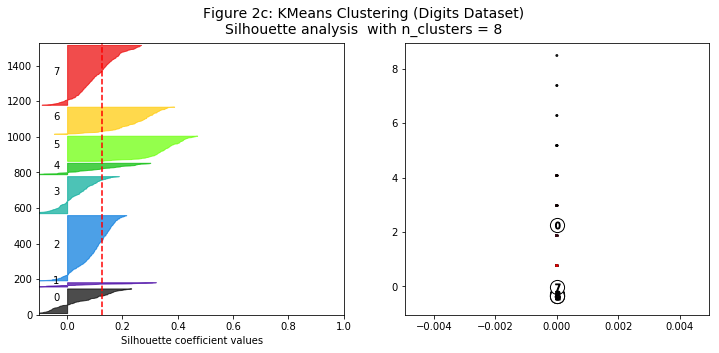

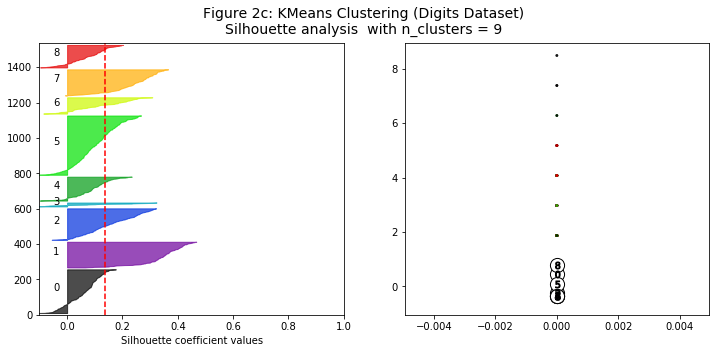

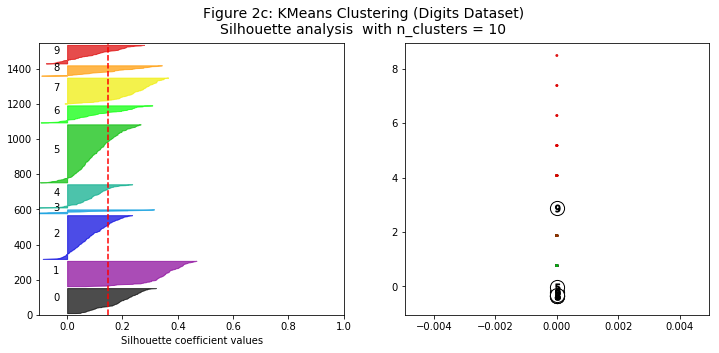

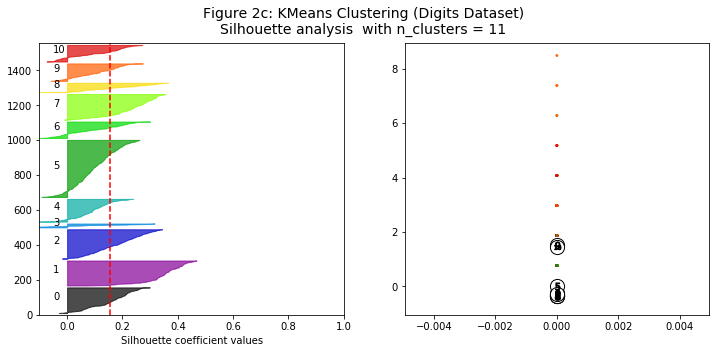

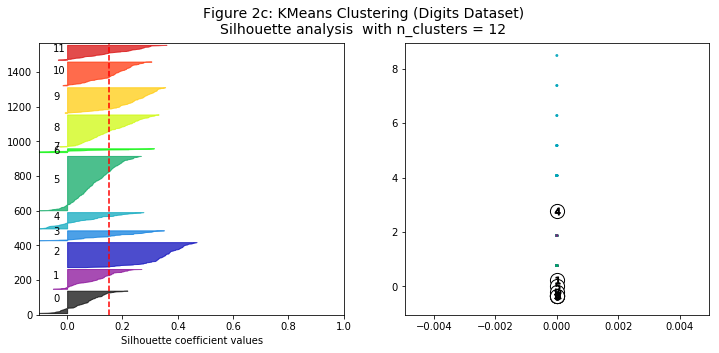

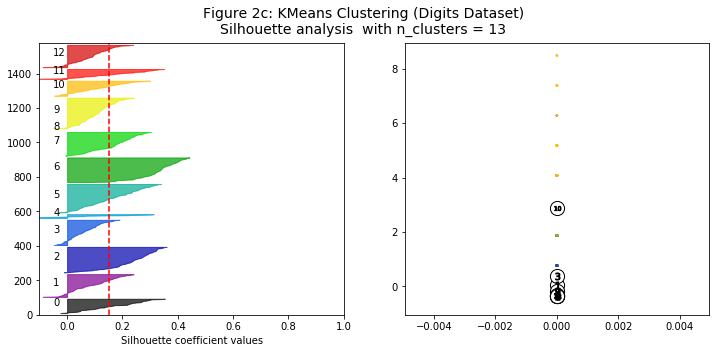

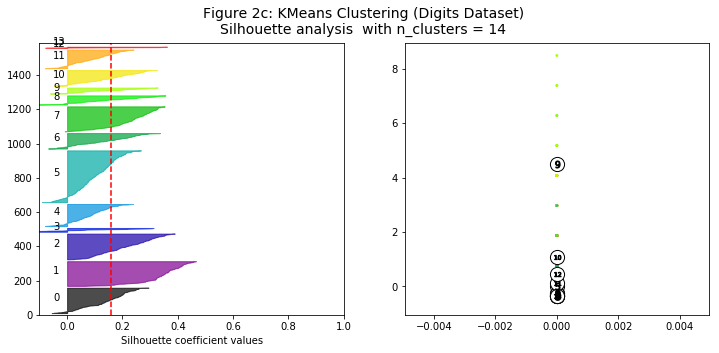

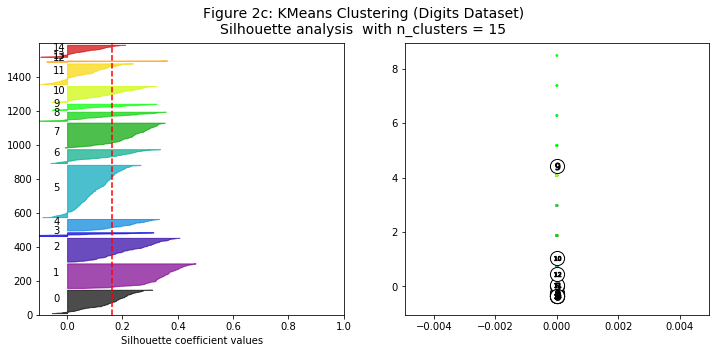

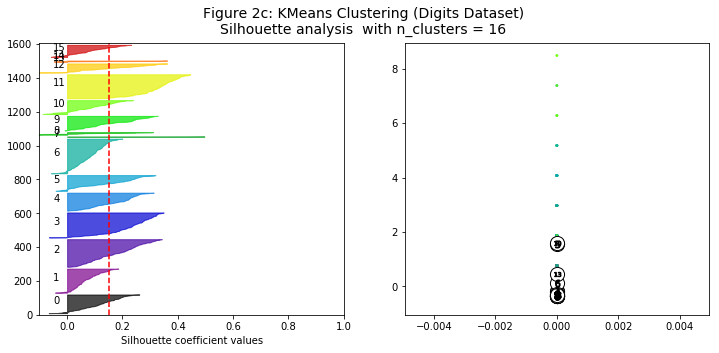

In [95]:
title = "Figure 2c: KMeans Clustering (Digits Dataset)\n"
kmeans_silhoutte(X_train, Y_train, title)

BIC score =  -178974.465301
BIC scores =  [ 254528.33821884  242750.67722207  234447.19464376  228975.87440234
  223377.09980457  216360.6117833   213890.3181781   213488.2003907
  206259.71704907  204605.11949135  203607.81881891  199923.02987659
  199682.60069558  198235.15439135  195550.01598517  195922.55027502
  194749.35356412  192370.9519966   191879.10944014  141655.35514775
  141214.14171151  140544.91764053  139778.57770701  138677.95153833
  137085.79079215  137420.82918973  137059.72377092  134400.26494234
  113803.93672093  132187.15450729  131605.48480678  131441.87090982
  107208.54644434  110036.47755897  109787.03366891   87552.44394403
  106619.80711161  107324.94545036  193704.13169464   24226.11253326
  -52876.10731397  -21445.82746659  -74971.56062709  -89494.61967341
 -103040.3383614  -115617.11943194 -112004.28231292 -116713.61663585
 -119849.4658346  -130495.08399555 -146053.40536587 -144211.45888748
 -150332.6234896  -165426.6565845  -157377.47412882 -175094.79

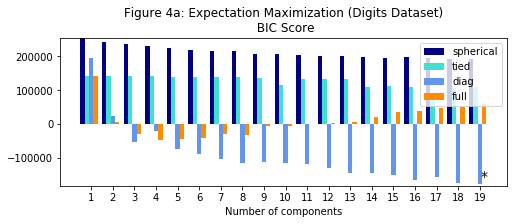

In [157]:
random.seed(55)
compute_bic_score(X_train, "Figure 4a: Expectation Maximization (Digits Dataset)\n BIC Score" , "Figure 4b: Cluster Representation")

In [70]:
random.seed(55)
#nn_arga = [(25,),(25,25),(50),(50,50)]
#nn_lr = [.001, .006, .01, .06, .1, .6]

nn_arga = [(50)]
nn_lr = [ 0.01]
def run_NN(dims, clf, X, Y):
    grid ={'clf__n_components':dims,'NN__learning_rate_init':nn_lr,'NN__hidden_layer_sizes':nn_arga}      
    mlp = MLPClassifier(activation='relu',max_iter=2000,early_stopping=True,random_state=5)
    pipe = Pipeline([('clf',clf),('NN',mlp)])
    gs = GridSearchCV(pipe,grid,verbose=10,cv=5)
    gs.fit(X, Y)
    #print("components = ", clf.components_)

    print("best estimator = ", gs.best_estimator_)
    print("best params = ", gs.best_params_)
    
    return (pd.DataFrame(gs.cv_results_) , gs.best_estimator_)

In [54]:
def pairwiseDistCorr(X1,X2):
    assert X1.shape[0] == X2.shape[0]
    
    d1 = pairwise_distances(X1)
    d2 = pairwise_distances(X2)
    return np.corrcoef(d1.ravel(),d2.ravel())[0,1]


In [55]:
# http://datascience.stackexchange.com/questions/6683/feature-selection-using-feature-importances-in-random-forests-with-scikit-learn          
class ImportanceSelect(BaseEstimator, TransformerMixin):
    def __init__(self, model, n=1):
         self.model = model
         self.n = n
    def fit(self, *args, **kwargs):
         self.model.fit(*args, **kwargs)
         return self
    def transform(self, X):
         return X[:,self.model.feature_importances_.argsort()[::-1][:self.n]]

In [108]:
#%% Part 2A & 4A - Run Dimensionality Reduction Algorithm PCA, Run NN with reduced dims

plt.figure(figsize=(6,4))
print('Part 2A - Starting PCA for Digits dataset')
pca = PCA(random_state=5)
pca.fit_transform(X_train)
explained_variance_ratio = pd.Series(data = pca.explained_variance_ratio_,index = range(1,65))
explained_variance_ratio.to_csv('./Part2/digits_PCA_explained_variance_ratio.csv')
#print("final =", pca.components_)
explained_variance = pd.Series(data = pca.explained_variance_,index = range(1,65))
explained_variance.to_csv('./Part2/digits_PCA_eigen_values.csv')

print("Reduced Dimension: {} out of {}".
      format(X_train.shape[1]-len([i for i in explained_variance_ratio if i >= 0.005]),X_train.shape[1]))
print("Variance captured: {} %".format(sum([i for i in explained_variance_ratio if i >= 0.005])*100.))

##run NN
pca = PCA(random_state=5)  
nn_results, clf = run_NN(dims_digits, pca, X_train, Y_train)     
nn_results.to_csv('./Part4/digits_PCA_nn_results.csv')

## test score

test_score = clf.score(X_test, Y_test)
print("Test Accuracy = ", test_score )
print("Best Estimator = ", clf)



Part 2A - Starting PCA for Digits dataset
Reduced Dimension: 28 out of 64
Variance captured: 93.55562853534852 %
Fitting 5 folds for each of 63 candidates, totalling 315 fits
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=2, score=0.47766323024054985, total=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=2, score=0.503448275862069, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=2, score=0.5505226480836237, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=2, score=0.5559440559440559, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=2, score=0.5759717314487632, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=3 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.5s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=3, score=0.7525773195876289, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=3, score=0.7137931034482758, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=3, score=0.6933797909407665, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=3, score=0.7657342657342657, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=3, score=0.6643109540636042, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=11, score=0.9195804195804196, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=11, score=0.8975265017667845, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=12, score=0.9312714776632303, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=12, score=0.9310344827586207, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=12, score=0.8989547038327527, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rat

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=20, score=0.9651567944250871, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=20, score=0.9335664335664335, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=20, score=0.9151943462897526, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=21, score=0.9278350515463918, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=21, score=0.9275862068965517, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rat

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=28, score=0.9512195121951219, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=28, score=0.9545454545454546, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=28, score=0.9469964664310954, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=29, score=0.9312714776632303, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=29, score=0.9689655172413794, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rat

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=36, score=0.911660777385159, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=37 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=37, score=0.9553264604810997, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=37 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=37, score=0.896551724137931, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=37 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=37, score=0.9686411149825784, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=37 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=37, score=0.951048951048951, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_i

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=45, score=0.9381443298969072, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=45 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=45, score=0.9586206896551724, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=45 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=45, score=0.9547038327526133, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=45 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=45, score=0.9475524475524476, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=45 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=45, score=0.9081272084805654, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rat

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=53, score=0.9151943462897526, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=54 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=54, score=0.9553264604810997, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=54 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=54, score=0.9172413793103448, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=54 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=54, score=0.9616724738675958, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=54 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=54, score=0.9545454545454546, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rat

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=62, score=0.9413793103448276, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=62 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=62, score=0.9686411149825784, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=62 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=62, score=0.9265734265734266, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=62 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=62, score=0.9151943462897526, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=63 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=63, score=0.9450171821305842, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rat

[Parallel(n_jobs=1)]: Done 315 out of 315 | elapsed:   15.4s finished


['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64']


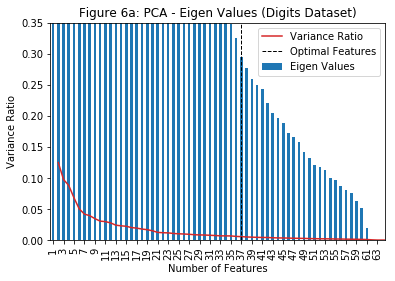

Reduced Dimension: 28 out of 64
Variance captured: 93.55562853534852 %


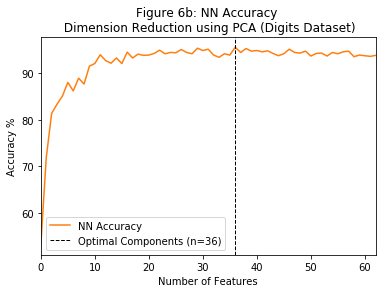

In [112]:
random.seed(55)
explained_variance_ratio.plot( ylim = (0.,0.35), color = 'tab:red',  label = "Variance Ratio" )
ax = explained_variance.plot(kind = 'bar',ylim = (0.,0.35),label = "Eigen Values")


ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::2])
ax.xaxis.set_ticklabels(ticklabels[::2]);
ax.axvline(x= 36, linestyle = "--", linewidth = 1, color = "k", label = "Optimal Features")

print(ticklabels)

plt.legend(loc='best')
plt.title("Figure 6a: PCA - Eigen Values (Digits Dataset)")
plt.xlabel("Number of Features")
plt.ylabel("Variance Ratio");
plt.show()
plt.close()

print("Reduced Dimension: {} out of {}".
      format(X_train.shape[1]-len([i for i in explained_variance_ratio if i >= 0.005]),X_train.shape[1]))
print("Variance captured: {} %".format(sum([i for i in explained_variance_ratio if i >= 0.005])*100.))

nn_results_pca = pd.read_csv("./Part4/digits_PCA_nn_results.csv", header = 'infer')
nn_results_pca = nn_results['mean_test_score'] * 100.0
#nn_train_results_pca = nn_results['mean_train_score'] * 100.0

nn_results_pca.plot( color = 'tab:orange',  label = "NN Accuracy" )
#nn_train_results_pca.plot( color = 'tab:green',  label = "NN Train Accuracy" )
plt.axvline(x=36 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Components (n=36)")

plt.legend(loc='best')
plt.title("Figure 6b: NN Accuracy \n Dimension Reduction using PCA (Digits Dataset)")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy %");
plt.show()
plt.close()

In [115]:
## Part 2 - DR algorithm ICA
print('Part 2B Starting ICA for digits dataset')
ica = FastICA(random_state=5)
kurt = {}
svm = {}
for dim in dims_digits:
    ica.set_params(n_components=dim)
    tmp = ica.fit_transform(X_train)
    tmp = pd.DataFrame(tmp)
    tmp2 = tmp.kurt(axis=0)
    kurt[dim] = tmp2.abs().mean()
  
kurt = pd.Series(kurt) 
kurt.to_csv('./Part2/digits_ICA_kurtosis.csv')

Part 2B Starting ICA for digits dataset


In [119]:
# Run Neural Networks
ica = FastICA(random_state=5)  
nn_results , clf = run_NN(dims_digits, ica, X_train, Y_train)     
nn_results.to_csv('./Part4/digits_ICA_nn_results.csv')

## test score

test_score = clf.score(X_test, Y_test)
print("Test Accuracy = ", test_score )
print("Best Estimator = ", clf)

Fitting 5 folds for each of 63 candidates, totalling 315 fits
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=2, score=0.4845360824742268, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=2, score=0.5344827586206896, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=2, score=0.6132404181184669, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=2, score=0.44755244755244755, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=2, score=0.38869257950530034, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=3 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=3, score=0.6701030927835051, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=3, score=0.6379310344827587, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=3, score=0.6829268292682927, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=3 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.8s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=3, score=0.6818181818181818, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=3, score=0.6749116607773852, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=4, score=0.738831615120275, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=4, score=0.7586206896551724, total=   0.2s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=4, score=0.6515679442508711, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.0

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=11, score=0.8636363636363636, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=11, score=0.8409893992932862, total=   0.2s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=12, score=0.9106529209621993, total=   0.2s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=12, score=0.8793103448275862, total=   0.3s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=12, score=0.9128919860627178, total=   0.2s
[CV] NN__hidden_layer_sizes=50, NN__learning_rat

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=19, score=0.9265734265734266, total=   0.2s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=19, score=0.833922261484099, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=20, score=0.9553264604810997, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=20, score=0.9379310344827586, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=20, score=0.9337979094076655, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=27, score=0.9545454545454546, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=27, score=0.9257950530035336, total=   0.2s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=28, score=0.9656357388316151, total=   0.3s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=28, score=0.9344827586206896, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=28, score=0.9547038327526133, total=   0.2s
[CV] NN__hidden_layer_sizes=50, NN__learning_rat

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=35, score=0.951048951048951, total=   0.2s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=35 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=35, score=0.8904593639575972, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=36 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=36, score=0.9621993127147767, total=   0.2s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=36 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=36, score=0.9482758620689655, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=36 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=36, score=0.9233449477351916, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=43, score=0.9328621908127208, total=   0.2s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=44 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=44, score=0.9553264604810997, total=   0.5s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=44 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=44, score=0.9448275862068966, total=   0.2s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=44 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=44, score=0.9407665505226481, total=   0.2s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=44 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=44, score=0.9370629370629371, total=   0.2s
[CV] NN__hidden_layer_sizes=50, NN__learning_rat

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=52, score=0.9828178694158075, total=   0.2s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=52 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=52, score=0.9344827586206896, total=   0.3s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=52 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=52, score=0.9512195121951219, total=   0.2s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=52 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=52, score=0.951048951048951, total=   0.3s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=52 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=52, score=0.9187279151943463, total=   0.2s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=60, score=0.9484536082474226, total=   0.8s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=60 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=60, score=0.9275862068965517, total=   0.5s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=60 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=60, score=0.9512195121951219, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=60 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=60, score=0.9475524475524476, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=60 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=60, score=0.9257950530035336, total=   0.3s
[CV] NN__hidden_layer_sizes=50, NN__learning_rat

[Parallel(n_jobs=1)]: Done 315 out of 315 | elapsed:  1.4min finished


best estimator =  Pipeline(memory=None,
     steps=[('clf', FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
    n_components=53, random_state=5, tol=0.0001, w_init=None, whiten=True)), ('NN', MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon...       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False))])
best params =  {'NN__hidden_layer_sizes': 50, 'NN__learning_rate_init': 0.06, 'clf__n_components': 53}
Test Accuracy =  0.966666666667
Best Estimator =  Pipeline(memory=None,
     steps=[('clf', FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
    n_components=53, random_state=5, tol=0.0001, w_init=None, whiten=True)), ('NN', MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon...       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=

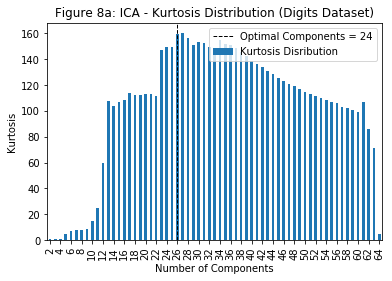

Reduced Dimension: 8 out of 64


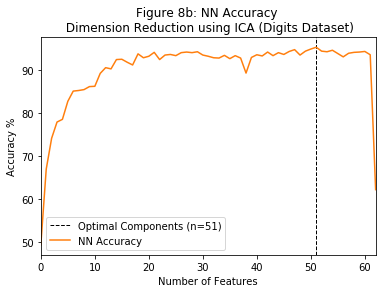

In [143]:
plt.figure(figsize=(6,4))
ax = kurt.plot(kind = 'bar', label = "Kurtosis Disribution");
ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::2])
ax.xaxis.set_ticklabels(ticklabels[::2]);
ax.axvline(x=24 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Components = 24")


plt.legend(loc='best')
plt.title("Figure 8a: ICA - Kurtosis Distribution (Digits Dataset)")
plt.xlabel("Number of Components")
plt.ylabel("Kurtosis");
plt.show()
plt.close()
#print(kurt)

print("Reduced Dimension: {} out of {}".format(X_train.shape[1]-len([i for i in kurt if i >= 8.]),
                                               X_train.shape[1]))

###
#best estimator =  Pipeline(memory=None,
#     steps=[('clf', FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
#    n_components=12, random_state=5, tol=0.0001, w_init=None, whiten=True)), ('NN', MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
#       beta_2=0.999, early_stopping=True, epsilon...       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
#       warm_start=False))])
#best params =  {'NN__hidden_layer_sizes': (50, 50), 'NN__learning_rate_init': 0.06, 'clf__n_components': 12}
###
nn_results_ica = pd.read_csv("./Part4/digits_ICA_nn_results.csv", header = 'infer')
nn_results_ica = nn_results['mean_test_score'] * 100.0
#nn_train_results_pca = nn_results['mean_train_score'] * 100.0
plt.axvline(x=51 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Components (n=51)")

nn_results_ica.plot( color = 'tab:orange',  label = "NN Accuracy" )
#nn_train_results_pca.plot( color = 'tab:green',  label = "NN Train Accuracy" )

plt.legend(loc='best')
plt.title("Figure 8b: NN Accuracy \n Dimension Reduction using ICA (Digits Dataset)")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy %");
plt.show()
plt.close()

In [131]:
print('Part 2 - Starting RP, pairwise distance correlation, for digits.')
tmp = defaultdict(dict)
for i,dim in product(range(10),dims_digits):
    rp = SparseRandomProjection(random_state=i, n_components=dim)
    tmp[dim][i] = pairwiseDistCorr(rp.fit_transform(X_train), X_train)

tmp = pd.DataFrame(tmp).T
tmp.to_csv('./Part2/digits_RP_pairwise_distance_corr.csv')


Part 2 - Starting RP, pairwise distance correlation, for digits.


In [83]:
# Run Neural Networks
rp = SparseRandomProjection(random_state=5) 
nn_results, clf = run_NN(dims_digits, rp,  X_train, Y_train)     
nn_results.to_csv('./Part4/digits_RP_nn_results.csv')

## test score

test_score = clf.score(X_test, Y_test)
print("Test Accuracy = ", test_score )
print("Best Estimator = ", clf)

Fitting 5 folds for each of 63 candidates, totalling 315 fits
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=2, score=0.3745704467353952, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=2, score=0.3793103448275862, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=2, score=0.3623693379790941, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=2, score=0.3531468531468531, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=2, score=0.3321554770318021, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=3, score=0.41237113402061853, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=3, score=0.4413793103448276, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=3, score=0.4564459930313589, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.5s remaining:    0.0s



[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=3, score=0.4160839160839161, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=3, score=0.42402826855123676, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=4, score=0.4329896907216495, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=4, score=0.3793103448275862, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=4, score=0.445993031358885, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=12, score=0.8172413793103448, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=12, score=0.8745644599303136, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=12, score=0.8671328671328671, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=12, score=0.8409893992932862, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=13, score=0.8144329896907216, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rat

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=20, score=0.9137931034482759, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=20, score=0.8641114982578397, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=20, score=0.8916083916083916, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=20, score=0.8692579505300353, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=21, score=0.9243986254295533, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rat

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=28, score=0.9310344827586207, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=28, score=0.9198606271777003, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=28, score=0.8951048951048951, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=28, score=0.8869257950530035, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=29, score=0.9175257731958762, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rat

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=36, score=0.9125874125874126, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=36 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=36, score=0.8657243816254417, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=37 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=37, score=0.9106529209621993, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=37 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=37, score=0.9310344827586207, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=37 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=37, score=0.9442508710801394, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rat

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=44, score=0.9045936395759717, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=45 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=45, score=0.9347079037800687, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=45 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=45, score=0.9551724137931035, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=45 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=45, score=0.9721254355400697, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=45 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=45, score=0.9475524475524476, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rat

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=53, score=0.9651567944250871, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=53 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=53, score=0.9405594405594405, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=53 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=53, score=0.8869257950530035, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=54 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=54, score=0.9278350515463918, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=54 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=54, score=0.8827586206896552, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rat

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=61, score=0.9125874125874126, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=61 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=61, score=0.901060070671378, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=62 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=62, score=0.9415807560137457, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=62 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=62, score=0.9482758620689655, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=62 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=62, score=0.9477351916376306, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate

[Parallel(n_jobs=1)]: Done 315 out of 315 | elapsed:   22.3s finished


In [124]:
def reconstructionError(projections,X):
    W = projections.components_
    if sps.issparse(W):
        W = W.todense()
    p = pinv(W)
    reconstructed = ((p@W)@(X.T)).T # Unproject projected data
    errors = np.square(X-reconstructed)
    return np.nanmean(errors)
 

In [133]:
temp1 = defaultdict(dict)
for i,dim in product(range(10),dims_digits):
    rp = SparseRandomProjection(random_state=i, n_components=dim)
    rp.fit(X_train)    
    temp1[dim][i] = reconstructionError(rp, X_train)
temp1 =pd.DataFrame(temp1).T
temp1.to_csv('./Part2/digits_RP_reconstruction_error.csv')


In [135]:
recon_error = pd.read_csv("./Part2/digits_RP_reconstruction_error.csv", header = 'infer')
recon_error['10'].head()

0    0.896228
1    0.881070
2    0.868382
3    0.862246
4    0.843430
Name: 10, dtype: float64

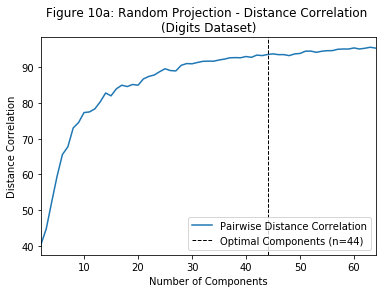

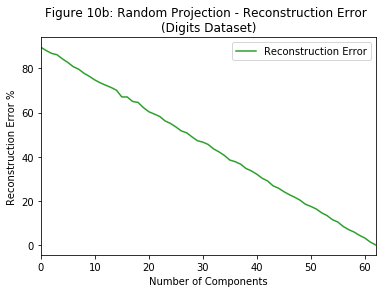

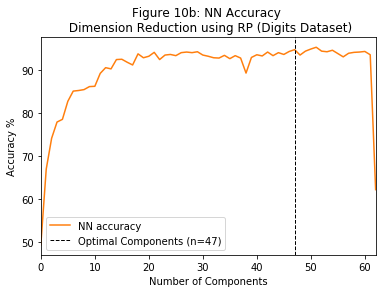

In [141]:
tmp['mean'] = tmp.mean(axis=1)

distance = tmp['mean']*100.0

distance.plot(color = 'tab:blue',  label = "Pairwise Distance Correlation" )
plt.axvline(x=44 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Components (n=44)")

plt.legend(loc='best')
plt.title("Figure 10a: Random Projection - Distance Correlation \n(Digits Dataset)")
plt.xlabel("Number of Components")
plt.ylabel("Distance Correlation");
plt.show()
plt.close()


t_recon = recon_error['10'] * 100.0
t_recon.plot( color = 'tab:green',  label = "Reconstruction Error" )
plt.legend(loc='best')
plt.title("Figure 10b: Random Projection - Reconstruction Error \n(Digits Dataset)")
plt.xlabel("Number of Components")
plt.ylabel("Reconstruction Error %");
plt.show()
plt.close()

nn_results_rp = pd.read_csv("./Part4/digits_RP_nn_results.csv", header = 'infer')
nn_results_rp = nn_results['mean_test_score'] * 100.0
#nn_train_results_pca = nn_results['mean_train_score'] * 100.0
nn_results_rp.plot( color = 'tab:orange',  label = "NN accuracy" )
plt.axvline(x=47 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Components (n=47)")

plt.legend(loc='best')
plt.title("Figure 10b: NN Accuracy \n Dimension Reduction using RP (Digits Dataset)")
plt.xlabel("Number of Components")
plt.ylabel("Accuracy %");
plt.show()
plt.close()

In [142]:
print('*** Part 2 - Start Dimension Reduction for Digits Dataset ***')

rfc = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=5, n_jobs=7)

fs_digits = rfc.fit(X_train, Y_train).feature_importances_ 

tmp = pd.Series(np.sort(fs_digits)[::-1])
tmp.to_csv('./Part2/digits_RF_feature_importance.csv')


*** Part 2 - Start Dimension Reduction for Digits Dataset ***


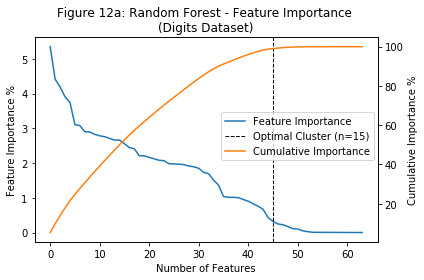

In [88]:
df1 = pd.read_csv("./Part2/digits_RF_feature_importance.csv", header=None)
x_data = df1[0] 

plt.figure(figsize = (12,8))
fig, ax1 = plt.subplots()
ax1.plot(x_data, df1[1]* 100.0, label = "Feature Importance" , color = "tab:blue",)
ax1.axvline(x=45 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Cluster (n=15)")
#reatins 90% feature importance
#plt.legend(loc='center right')

ax2 = ax1.twinx() 
ax2.plot(x_data, df1[2]*100.0, label = "Cumulative Importance" , color = "tab:orange",)

#ax1.legend(loc='center right')
fig.legend(loc='center left', bbox_to_anchor=(0.5, 0.5))
plt.title("Figure 12a: Random Forest - Feature Importance \n(Digits Dataset)")
ax1.set_xlabel("Number of Features")
ax1.set_ylabel("Feature Importance %")
ax2.set_ylabel("Cumulative Importance %")
fig.tight_layout() 

plt.show()
plt.close()

In [90]:
nn_arga = [(50)]
nn_lr = [0.06]

rfc = RandomForestClassifier(n_estimators=100,class_weight='balanced',random_state=5,n_jobs=7)
filtr = ImportanceSelect(rfc)
grid ={'filter__n':dims_digits,'NN__learning_rate_init':nn_lr,'NN__hidden_layer_sizes':nn_arga}  
mlp = MLPClassifier(activation='relu',max_iter=2000,early_stopping=True,random_state=5)
pipe = Pipeline([('filter',filtr),('NN',mlp)])
gs = GridSearchCV(pipe,grid,verbose=10,cv=5)
gs.fit(X_train, Y_train)
nn_results = pd.DataFrame(gs.cv_results_)
nn_results.to_csv('./Part4/digits_RF_nn_results.csv')

print("best estimator = ", gs.best_estimator_)
print("best params = ", gs.best_params_)

Fitting 5 folds for each of 63 candidates, totalling 315 fits
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=2, score=0.3951890034364261, total=   0.6s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=2, score=0.3724137931034483, total=   0.5s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=2, score=0.37630662020905925, total=   0.5s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=2 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.0s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=2, score=0.34265734265734266, total=   0.5s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=2 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.6s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=2, score=0.4275618374558304, total=   0.6s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=3 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.3s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=3, score=0.4948453608247423, total=   0.6s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=3 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.0s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=3, score=0.5655172413793104, total=   0.6s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=3 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    4.7s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=3, score=0.46689895470383275, total=   0.5s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=3 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    5.3s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=3, score=0.4755244755244755, total=   0.5s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=3 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    6.0s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=3, score=0.5653710247349824, total=   0.5s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=4, score=0.5738831615120275, total=   0.6s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=4, score=0.5896551724137931, total=   0.5s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=4, score=0.6236933797909407, total=   0.5s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=4, score=0.6048951048951049, total=   0.5s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=12, score=0.8811188811188811, total=   0.5s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=12 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=12, score=0.911660777385159, total=   0.6s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=13 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=13, score=0.8694158075601375, total=   0.5s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=13 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=13, score=0.8724137931034482, total=   0.5s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=13 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=13, score=0.8815331010452961, total=   0.6s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=13 
[CV]  NN__hidden_layer_sizes=50, NN__learning_

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=21, score=0.9310344827586207, total=   0.5s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=21 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=21, score=0.9477351916376306, total=   0.5s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=21 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=21, score=0.9440559440559441, total=   0.5s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=21 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=21, score=0.9293286219081273, total=   0.6s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=22 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=22, score=0.9587628865979382, total=   0.6s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=22 
[CV]  NN__hidden_layer_sizes=50, NN__learning

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=29, score=0.9328621908127208, total=   0.5s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=30 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=30, score=0.9518900343642611, total=   0.5s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=30 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=30, score=0.9344827586206896, total=   0.5s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=30 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=30, score=0.9442508710801394, total=   0.5s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=30 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=30, score=0.9755244755244755, total=   0.6s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=30 
[CV]  NN__hidden_layer_sizes=50, NN__learning

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=38, score=0.975609756097561, total=   0.6s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=38 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=38, score=0.958041958041958, total=   0.6s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=38 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=38, score=0.9328621908127208, total=   0.5s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=39 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=39, score=0.9621993127147767, total=   0.5s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=39 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=39, score=0.9448275862068966, total=   0.5s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=39 
[CV]  NN__hidden_layer_sizes=50, NN__learning_r

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=47, score=0.9415807560137457, total=   0.5s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=47 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=47, score=0.9241379310344827, total=   0.5s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=47 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=47, score=0.9651567944250871, total=   0.6s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=47 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=47, score=0.9335664335664335, total=   0.6s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=47 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=47, score=0.9469964664310954, total=   0.5s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=48 
[CV]  NN__hidden_layer_sizes=50, NN__learning

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=55, score=0.951048951048951, total=   0.5s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=55 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=55, score=0.9293286219081273, total=   0.5s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=56 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=56, score=0.9518900343642611, total=   0.5s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=56 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=56, score=0.9413793103448276, total=   0.6s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=56 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=56, score=0.9477351916376306, total=   0.5s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=56 
[CV]  NN__hidden_layer_sizes=50, NN__learning_

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=64, score=0.9482758620689655, total=   0.5s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=64 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=64, score=0.9581881533101045, total=   0.6s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=64 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=64, score=0.965034965034965, total=   0.6s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=64 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=64, score=0.9328621908127208, total=   0.6s


[Parallel(n_jobs=1)]: Done 315 out of 315 | elapsed:  3.5min finished


best estimator =  Pipeline(memory=None,
     steps=[('filter', ImportanceSelect(model=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
           ...       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False))])
best params =  {'NN__hidden_layer_sizes': 50, 'NN__learning_rate_init': 0.06, 'filter__n': 33}


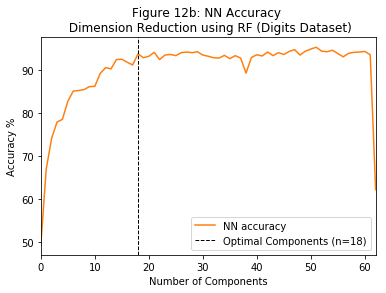

Test Accuracy =  0.969444444444
Best Estimator =  Pipeline(memory=None,
     steps=[('filter', ImportanceSelect(model=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
           ...       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False))])


In [146]:
nn_results_rf = pd.read_csv("./Part4/digits_RF_nn_results.csv", header = 'infer')
nn_results_rf = nn_results['mean_test_score'] * 100.0
#nn_train_results_pca = nn_results['mean_train_score'] * 100.0
nn_results_rf.plot( color = 'tab:orange',  label = "NN accuracy" )
plt.axvline(x=18 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Components (n=18)")

plt.legend(loc='best')
plt.title("Figure 12b: NN Accuracy \n Dimension Reduction using RF (Digits Dataset)")
plt.xlabel("Number of Components")
plt.ylabel("Accuracy %");
plt.show()
plt.close()

clf = gs.best_estimator_
## test score

test_score = clf.score(X_test, Y_test)
print("Test Accuracy = ", test_score )
print("Best Estimator = ", clf)

### Part 3

In [93]:
dim_PCA = 39
dim_ICA = 53
dim_RP = 40 
dim_RF = 40 

rfc = RandomForestClassifier(n_estimators = 100, class_weight = 'balanced', random_state =5, n_jobs = 7)

algo_name = ['PCA', 'ICA', 'RP', 'RF']

filter_ = ImportanceSelect(rfc,dim_RF)

algos = [PCA(n_components=dim_PCA,random_state=10), 
           FastICA(n_components=dim_ICA,random_state=10), 
           SparseRandomProjection(n_components=dim_RP,random_state=5),
           ImportanceSelect(rfc,dim_RF)]

for i in range(len(algos)):
    if i == 3:
        X2 = algos[i].fit_transform(X_train, Y_train)
    else:   
        X2 = algos[i].fit_transform(X_train)
    data2 = pd.DataFrame(np.hstack((X2,np.atleast_2d(Y_train).T)))
    cols = list(range(data2.shape[1]))
    cols[-1] = 'Class'
    data2.columns = cols
    data2.to_hdf('datasets.hdf','digits_'+algo_name[i],complib='blosc',complevel=9)

Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,      10,      11,      12,      13,      14,      15,
            16,      17,      18,      19,      20,      21,      22,      23,
            24,      25,      26,      27,      28,      29,      30,      31,
            32,      33,      34,      35,      36,      37,      38, 'Class'],
      dtype='object')
BIC score =  87915.1598404
BIC scores =  [ 159333.95694825  149724.56973215  148423.11816848  147940.77528478
  145913.25441692  146497.82505033  144491.95914593  143945.73124421
  143484.20196008  143523.92182283  143174.49088459  143126.90058962
  141791.11747226  142226.91447401  141971.56205011  141387.57883109
  141146.31256542  140434.74518945  140843.95585451  164997.53068651
  164989.71606551  163628.89661701  163036.12981505  160913.4209507
  153907.83002259  160603.58840561  157743.02782277  146189.27014568
  155778.69092942  156796.07248142  141962.87123107  142535

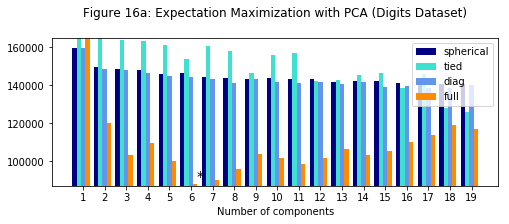

Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,      10,      11,      12,      13,      14,      15,
            16,      17,      18,      19,      20,      21,      22,      23,
            24,      25,      26,      27,      28,      29,      30,      31,
            32,      33,      34,      35,      36,      37,      38,      39,
            40,      41,      42,      43,      44,      45,      46,      47,
            48,      49,      50,      51,      52, 'Class'],
      dtype='object')
BIC score =  90408.1093139
BIC scores =  [ 216528.15215069  207337.9585877   205820.86751215  205643.62700194
  204693.11504939  203756.78162421  205086.90910349  202861.03181828
  202795.9382891   202620.72405147  201104.47817598  201564.9188726
  200587.17413748  200849.36910491  199892.83900954  200229.45198032
  199303.40614007  199612.6494738   200294.77711237  226924.69957778
  226470.35175044  226017.61249143  214940.37953909  2143

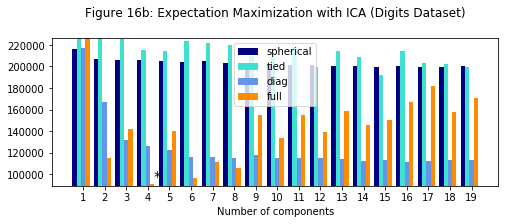

Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,      10,      11,      12,      13,      14,      15,
            16,      17,      18,      19,      20,      21,      22,      23,
            24,      25,      26,      27,      28,      29,      30,      31,
            32,      33,      34,      35,      36,      37,      38,      39,
       'Class'],
      dtype='object')
BIC score =  98292.3614348
BIC scores =  [ 163419.25660557  157704.53668268  154151.58298288  151434.7702639
  145165.12724092  143146.58662216  141066.2004151   139268.36810191
  139415.68820273  137255.00079565  134897.96859491  134011.69823831
  133303.31790093  131834.21594206  132281.03227326  130878.20963135
  130614.74905597  130454.2754568   129557.47913953  119056.87778959
  118505.30037445  118322.65026205  117627.51468306  116382.8036641
  115653.99166917  115517.71404358  114667.41381215  113987.28524582
  110212.18596658  112171.94623808  111766.0

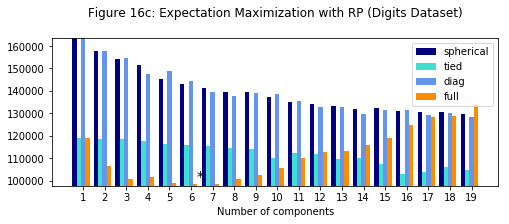

Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,      10,      11,      12,      13,      14,      15,
            16,      17,      18,      19,      20,      21,      22,      23,
            24,      25,      26,      27,      28,      29,      30,      31,
            32,      33,      34,      35,      36,      37,      38,      39,
       'Class'],
      dtype='object')
BIC score =  66408.744909
BIC scores =  [ 163419.25660557  158295.91650914  154601.39597613  150268.87503552
  145866.98430287  144259.10250099  142207.07827426  138865.98878699
  137591.4110413   135634.9320835   134737.82176642  135507.83377921
  133667.56597921  132295.19396287  132540.80321959  130284.01341185
  129977.75684819  129198.76931439  128957.94781932  124102.4237113
  123369.94469164  122638.17297541  121901.90357163  121058.47391277
  119951.3201206   119828.83027746  118533.48038762  117496.18297739
  116935.08083142  116351.3359651   116099.1

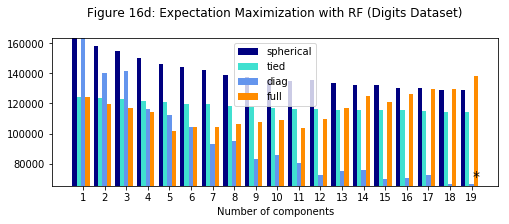

In [156]:
#random.seed(55)

titles = ["Figure 14a: KMeans Clustering with PCA (Digits Dataset)\n",
          "Figure 14b: KMeans Clustering with ICA (Digits Dataset)\n",
          "Figure 14c: KMeans Clustering with RP (Digits Dataset)\n",
          "Figure 14d: KMeans Clustering with RF (Digits Dataset)\n"]

titles_bic_1 = ["Figure 16a: Expectation Maximization with PCA (Digits Dataset)\n",
          "Figure 16b: Expectation Maximization with ICA (Digits Dataset)\n",
          "Figure 16c: Expectation Maximization with RP (Digits Dataset)\n",
          "Figure 16d: Expectation Maximization with RF (Digits Dataset)\n"]

titles_bic_2 = "Cluster Representation"

algo_name = ['PCA', 'ICA', 'RP', 'RF']
for i in range(len(algo_name)):
    # load datasets      
    temp = pd.read_hdf('datasets.hdf','digits_'+algo_name[i]) 
    print(temp.columns)
    tempX = temp.drop('Class',1).copy().values
    tempY = temp['Class'].copy().values
    
    tempX = StandardScaler().fit_transform(tempX)
    
    #kmeans_silhoutte(tempX, tempY, titles[i])
    compute_bic_score(tempX , titles_bic_1[i], titles_bic_2)

In [151]:
clusters = [6,7,8,9,10,11,12,13,14,15,16]

algo_name = ['PCA', 'ICA', 'RP', 'RF']
for i in range(len(algo_name)):
    # load datasets      
    temp = pd.read_hdf('datasets.hdf','digits_'+algo_name[i]) 
    print(temp.columns)
    tempX = temp.drop('Class',1).copy().values
    tempY = temp['Class'].copy().values
    
    tempX = StandardScaler().fit_transform(tempX)

    for k in clusters:
        km.set_params(n_clusters=k)
        #gmm.set_params(n_components=k)
    
        km = km.fit(tempX)
        #gmm.fit(X_train)
        #SSE[k]['Cancer'] = km.score(X_train)
        print("Sum of squared distances for ", algo_name[i], " for clusters = ", k , " = ",  km.inertia_)

Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,      10,      11,      12,      13,      14,      15,
            16,      17,      18,      19,      20,      21,      22,      23,
            24,      25,      26,      27,      28,      29,      30,      31,
            32,      33,      34,      35,      36,      37,      38, 'Class'],
      dtype='object')
Sum of squared distances for  PCA  for clusters =  6  =  50062.7135811
Sum of squared distances for  PCA  for clusters =  7  =  48896.3699453
Sum of squared distances for  PCA  for clusters =  8  =  47441.5535657
Sum of squared distances for  PCA  for clusters =  9  =  46638.1746592
Sum of squared distances for  PCA  for clusters =  10  =  45834.5832023
Sum of squared distances for  PCA  for clusters =  11  =  44644.4322272
Sum of squared distances for  PCA  for clusters =  12  =  43741.0040774
Sum of squared distances for  PCA  for clusters =  13  =  42754.5891867
Sum of squ